In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf
from mfsetup import MF6model
from mfsetup.discretization import cellids_to_kij
from gisutils import df2shp
import mfexport

flopy is installed in /Users/aleaf/Documents/GitHub/flopy/flopy


In [2]:
m = MF6model.setup_from_yaml('pleasant_lgr_parent.yml')

loading configuration file pleasant_lgr_parent.yml...

Setting up plsnt_lgr_parent model from data in None


arguments to ModflowGwf:
modelname: plsnt_lgr_parent
version: mf6
simulation: sim_name = pleasant_lgr
sim_path = /Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr
exe_name = mf6

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = pleasant_lgr



list: /Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr/plsnt_lgr_parent.list
print_input: True
print_flows: False
save_flows: True
newtonoptions: ['under_relaxation']

other arguments:
list_filename_fmt: {}.list
options: {'newton': True,
 'newton_under_relaxation': True,
 'newtonoptions': ['under_relaxation'],
 'print_flows': False,
 'print_input': True,
 'save_flows': True}
packages: ['dis', 'ic', 'npf', 'oc', 'sto', 'rch', 'sfr', 'lak', 'obs', 'wel', 'ims']
hiKlakes_value: 

computing cell thicknesses...
finished in 0.02s

wrote original/plsnt_lgr_parent_lakarr0.dat, took 0.00s
wrote original/plsnt_lgr_parent_lakarr1.dat, took 0.00s
wrote original/plsnt_lgr_parent_lakarr2.dat, took 0.00s
wrote original/plsnt_lgr_parent_lakarr3.dat, took 0.00s
wrote original/plsnt_lgr_parent_lakarr4.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_idomain0.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_idomain1.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_idomain2.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_idomain3.dat, took 0.00s
wrote ./external/plsnt_lgr_parent_idomain4.dat, took 0.00s
finished in 0.28s


arguments to setup_structured_grid:
rotation: 0
snap_to_NHG: False
dxy: 40
buffer: 1000
grid_file: /Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr/plsnt_lgr_inset_grid.json
epsg: 3070
id_column: HYDROID
include_ids: [600059060]
features_shapefile: /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/shps/all_la

filtering on bounding box -89.5911225596923, 43.965959882234365, -89.52843935935044, 44.01121639579922...
--> building dataframe... (may take a while for large shapefiles)

reading /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/shps/NHDPlusAttributes/PlusFlowlineVAA.dbf...
--> building dataframe... (may take a while for large shapefiles)

reading /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/shps/NHDPlusAttributes/PlusFlow.dbf...
--> building dataframe... (may take a while for large shapefiles)

reading /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/shps/NHDPlusAttributes/elevslope.dbf...
--> building dataframe... (may take a while for large shapefiles)

load finished in 0.05s

Getting routing information from NHDPlus Plusflow table...
finished in 0.02s


SFRmaker version 0.3.0.post7+g7690b2b

Creating sfr dataset...

Creating grid class instance from flopy Grid instance...
grid class creat


arguments to ModflowGwfchd:
print_input: False
print_flows: False
save_flows: True

other arguments:


finished in 2.25s


Setting up DIS package...

arguments to ArraySourceData:
length_units: meters
filenames: {0: '/Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/rasters/dem40m.tif'}

other arguments:



arguments to ArraySourceData:
datatype: array2d
variable: top
dest_model: plsnt_lgr_inset model:
5 layer(s), 70 row(s), 80 column(s), 13 stress period(s)
Parent model: ./plsnt_lgr_parent
CRS: epsg:3070
(epsg: 3070)
Bounds: (554200.0, 557400.0, 389000.0, 391800.0)
Grid spacing: 40.00 meters
Packages:
vmin: -1e+30
vmax: 1e+30
resample_method: linear

other arguments:


reading data from /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/rasters/dem40m.tif...
finished in 0.03s
wrote ./external/plsnt_lgr_inset_top.dat, took 0.00s

arguments to ArraySourceData:
filenames: {1: '/Users/aleaf/Documents/GitHub/modflow-setup/examples/d


arguments to MFsetupGrid:
delr: [40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0]
delc: [40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 4


arguments to PrismSourceData:
filenames: {600059060: '/Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/PRISM_ppt_tmean_stable_4km_189501_201901_43.9850_-89.5522.csv'}
period_stats: {0: ['mean', '2012-01-01', '2018-12-31'], 1: 'mean'}

other arguments:
format: prism



arguments to PrismSourceData:
dest_model: plsnt_lgr_inset model:
5 layer(s), 70 row(s), 80 column(s), 13 stress period(s)
Parent model: ./plsnt_lgr_parent
CRS: epsg:3070
(epsg: 3070)
Bounds: (554200.0, 557400.0, 389000.0, 391800.0)
Grid spacing: 40.00 meters
Packages: dis ic npf sto

other arguments:


wrote ./external/plsnt_lgr_inset_rch0.dat, took 0.00s
wrote ./external/plsnt_lgr_inset_rch1.dat, took 0.00s
wrote ./external/plsnt_lgr_inset_rch2.dat, took 0.00s
wrote ./external/plsnt_lgr_inset_rch3.dat, took 0.00s
wrote ./external/plsnt_lgr_inset_rch4.dat, took 0.01s
wrote ./external/plsnt_lgr_inset_rch5.dat, took 0.00s
wrote ./external/plsnt_lgr_inset_rch6.dat, took 0.00s
wrote ./external/p


arguments to ModflowGwflak:
save_flows: True
boundnames: True
surfdep: 0.1
time_conversion: 86400.0
length_conversion: 1.0
nlakes: 1
noutlets: 0
packagedata: [[0, 298.38, 549, '']]
connectiondata: [[0, 0, (2, 36, 53), 'vertical', 0.025, 0.0, 0.0, 0.0, 0.0],
 [0, 1, (2, 40, 41), 'vertical', 0.025, 0.0, 0.0, 0.0, 0.0],
 [0, 2, (1, 29, 50), 'vertical', 0.025, 0.0, 0.0, 0.0, 0.0],
 [0, 3, (2, 40, 50), 'vertical', 0.025, 0.0, 0.0, 0.0, 0.0],
 [0, 4, (1, 41, 33), 'vertical', 0.025, 0.0, 0.0, 0.0, 0.0],
 [0, 5, (1, 44, 29), 'vertical', 0.045, 0.0, 0.0, 0.0, 0.0],
 [0, 6, (2, 41, 42), 'vertical', 0.025, 0.0, 0.0, 0.0, 0.0],
 [0, 7, (3, 33, 38), 'vertical', 0.025, 0.0, 0.0, 0.0, 0.0],
 [0, 8, (2, 41, 51), 'vertical', 0.025, 0.0, 0.0, 0.0, 0.0],
 [0, 9, (1, 33, 47), 'vertical', 0.025, 0.0, 0.0, 0.0, 0.0],
 [0, 10, (2, 44, 47), 'vertical', 0.025, 0.0, 0.0, 0.0, 0.0],
 [0, 11, (1, 45, 30), 'vertical', 0.045, 0.0, 0.0, 0.0, 0.0],
 [0, 12, (2, 37, 35), 'vertical', 0.025, 0.0, 0.0, 0.0, 0.0],
 [0, 1

finished in 0.20s


reading /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/shps/csls_sources_wu_pts.shp...
--> building dataframe... (may take a while for large shapefiles)
intersecting wells with model grid...
getting i, j locations...
finished in 0.00s

took 0.00s

computing cell thicknesses...
finished in 0.19s


Resampling pumping rates in /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/source_data/tables/master_wu.csv to model stress periods...
    wells with no data for a stress period will be assigned 0.0 pumping rates.
took 0.02s


arguments to ModflowGwfwel:
print_input: True
print_flows: True
save_flows: True
stress_period_data: {0: rec.array([((4, 16, 24), 0., 'site24426'), ((4, 10, 67), 0., 'site6707')],
          dtype=[('cellid', 'O'), ('q', '<f8'), ('boundname', 'O')]),
 1: rec.array([((4, 16, 24), 0., 'site24426'), ((4, 10, 67), 0., 'site6707')],
          dtype=[('cellid', 'O'), ('q', '<f8'), ('boundname', 'O')]),
 2: 

In [3]:
m

plsnt_lgr_parent model:
5 layer(s), 25 row(s), 25 column(s), 13 stress period(s)
Parent model: /Users/aleaf/Documents/GitHub/modflow-setup/examples/data/pleasant/pleasant
CRS: epsg:3070
(epsg: 3070)
Bounds: (552800.0, 557800.0, 388200.0, 393200.0)
Grid spacing: 200.00 meters
Packages: dis ic npf sto rcha oc sfr wel_0 obs_0 chd_0

In [4]:
m.cfg.keys()

dict_keys(['simulation', 'model', 'parent', 'intermediate_data', 'postprocessing', 'setup_grid', 'dis', 'tdis', 'ic', 'npf', 'sto', 'rch', 'sfr', 'lak', 'wel', 'chd', 'oc', 'obs', 'ims', 'filename', 'ghb', 'maw', 'external_files', 'grid'])

In [5]:
m.cfg['dis']

defaultdict(dict,
            {'options': {'length_units': 'meters'},
             'dimensions': {'nlay': 5},
             'griddata': {'top': [{'filename': './external/plsnt_lgr_parent_top.dat'}],
              'botm': [{'filename': './external/plsnt_lgr_parent_botm0.dat'},
               {'filename': './external/plsnt_lgr_parent_botm1.dat'},
               {'filename': './external/plsnt_lgr_parent_botm2.dat'},
               {'filename': './external/plsnt_lgr_parent_botm3.dat'},
               {'filename': './external/plsnt_lgr_parent_botm4.dat'}],
              'idomain': [{'filename': './external/plsnt_lgr_parent_idomain0.dat'},
               {'filename': './external/plsnt_lgr_parent_idomain1.dat'},
               {'filename': './external/plsnt_lgr_parent_idomain2.dat'},
               {'filename': './external/plsnt_lgr_parent_idomain3.dat'},
               {'filename': './external/plsnt_lgr_parent_idomain4.dat'}]},
             'top_filename_fmt': 'top.dat',
             'botm_fi

In [6]:
m.inset

{'plsnt_lgr_inset': plsnt_lgr_inset model:
 5 layer(s), 70 row(s), 80 column(s), 13 stress period(s)
 Parent model: ./plsnt_lgr_parent
 CRS: epsg:3070
 (epsg: 3070)
 Bounds: (554200.0, 557400.0, 389000.0, 391800.0)
 Grid spacing: 40.00 meters
 Packages: dis ic npf sto rcha oc sfr lak obs_0 wel_0 obs_1}

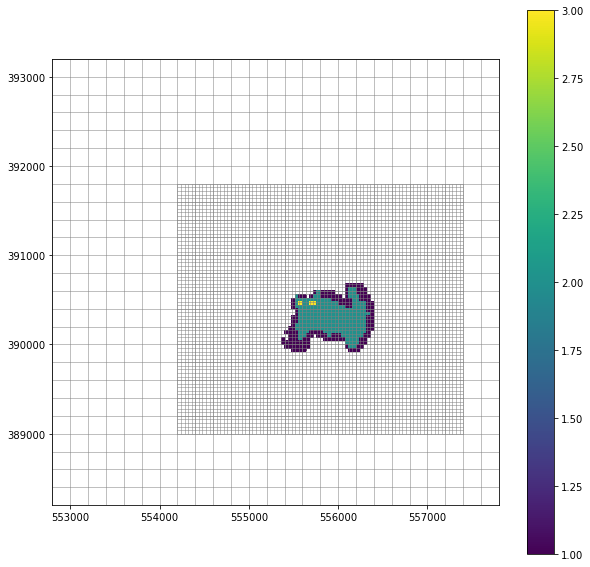

In [7]:
inset = m.inset['plsnt_lgr_inset']

l, r, b, t = m.modelgrid.extent
layer = 0

fig, ax = plt.subplots(figsize=(10, 10))
parent_mv = flopy.plot.PlotMapView(model=m, ax=ax, layer=layer)
inset_mv = flopy.plot.PlotMapView(model=inset, ax=ax, layer=layer)

vconn = inset.lak.connectiondata.array[inset.lak.connectiondata.array['claktype'] == 'vertical']
k, i, j = cellids_to_kij(vconn['cellid'])
lakeconnections = np.zeros((inset.nrow, inset.ncol))
lakeconnections[i, j] = np.array(k)
lakeconnections = np.ma.masked_array(lakeconnections, mask=lakeconnections == 0)
qmi = inset_mv.plot_array(lakeconnections)

#inset_mv.plot_bc('LAK', color='navy')
#parent_mv.plot_bc('WEL_0', color='red')

lcp = parent_mv.plot_grid(lw=0.5, ax=ax)
lci = inset_mv.plot_grid(lw=0.5)
ax.set_ylim(b, t)
ax.set_xlim(l, r)
ax.set_aspect(1)
plt.colorbar(qmi)

In [8]:
m.write_input()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing package pleasant_lgr.gwfgwf...
  writing model plsnt_lgr_parent...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha...
    writing package oc...
    writing package sfr...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
    writing package obs_0...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 235 based on size of stress_period_data
  writing model plsnt_lgr_inset...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha...
    writing package oc...
    writing package sfr...
    writing package lak...
 

In [9]:
# write the SFR package again using SFRmaker,
# because flopy doesn't check the packagedata against the idomain before writing
for model in m, m.inset['plsnt_lgr_inset']:
    if hasattr(model, 'sfr'):
        sfr_package_filename = os.path.join(model.model_ws, model.sfr.filename)
        model.sfrdata.write_package(sfr_package_filename,
                                    idomain=model.dis.idomain.array,
                                    version='mf6'
                                    )

converting segment data to period data...
converting reach and segment data to package data...
wrote ./plsnt_lgr_parent.sfr
converting segment data to period data...
converting reach and segment data to package data...
wrote ./plsnt_lgr_inset.sfr


In [10]:
m.simulation.run_simulation()

FloPy is using the following  executable to run the model: /Users/aleaf/Documents/software/pymake_exes/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.1.0 12/12/2019

   MODFLOW 6 compiled Dec 13 2019 12:29:49 with IFORT compiler (ver. 19.0.5)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to 

(True, [])

In [11]:
os.getcwd()

'/Users/aleaf/Documents/GitHub/modflow-setup/examples/pleasant_lgr'

In [12]:
tmr_parent_headsobj = bf.HeadFile('../data/pleasant/pleasant.hds')
lgr_parent_headsobj = bf.HeadFile('plsnt_lgr_parent.hds')
lgr_inset_headsobj = bf.HeadFile('plsnt_lgr_inset.hds')

tmr_parent_hds = tmr_parent_headsobj.get_data(kstpkper=(4, 12))
lgr_parent_hds = lgr_parent_headsobj.get_data(kstpkper=(0, 12))
lgr_inset_hds = lgr_inset_headsobj.get_data(kstpkper=(0, 12))

lgr_parent_hds = np.ma.masked_array(lgr_parent_hds, mask=lgr_parent_hds == 1e30)
lgr_inset_hds = np.ma.masked_array(lgr_inset_hds, mask=lgr_inset_hds == 1e30)

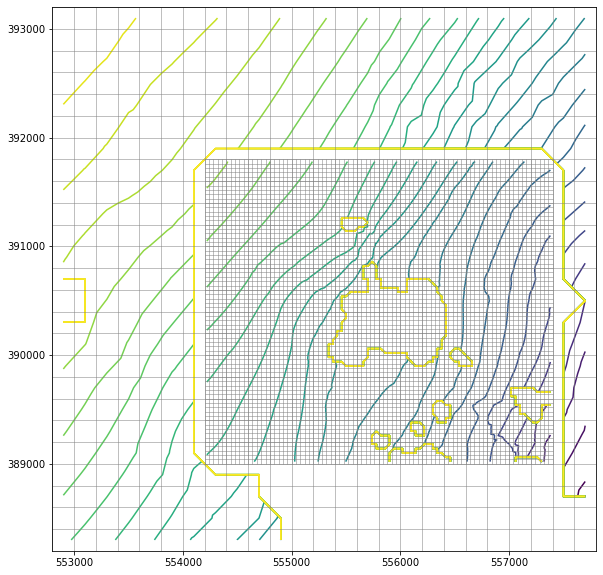

In [13]:
layer = 0

fig, ax = plt.subplots(figsize=(10, 10))
parent_mv = flopy.plot.PlotMapView(model=m, ax=ax, layer=layer)
inset_mv = flopy.plot.PlotMapView(model=inset, ax=ax, layer=layer)

pctr = parent_mv.contour_array(lgr_parent_hds, levels=np.arange(290, 315))
ictr = inset_mv.contour_array(lgr_inset_hds, levels=np.arange(290, 315))
#qmp = parent_mv.plot_array(lgr_parent_hds)
#qmi = inset_mv.plot_array(lgr_inset_hds)

lcp = parent_mv.plot_grid(lw=0.5, ax=ax)
lci = inset_mv.plot_grid(lw=0.5)
ax.set_ylim(b, t)
ax.set_xlim(l, r)
ax.set_aspect(1)
#plt.colorbar(qmp)

In [14]:
for model in m, inset:
    mfexport.export(model, model.modelgrid, output_path='postproc/{}/'.format(model.name))


dis package...
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay0.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay1.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay2.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay3.tif
wrote postproc/plsnt_lgr_parent/rasters/thickness_lay4.tif
top:
wrote postproc/plsnt_lgr_parent/rasters/top.tif
botm:
wrote postproc/plsnt_lgr_parent/rasters/botm_lay0.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay1.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay2.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay3.tif
wrote postproc/plsnt_lgr_parent/rasters/botm_lay4.tif
idomain:
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay0.tif
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay1.tif
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay2.tif
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay3.tif
wrote postproc/plsnt_lgr_parent/rasters/idomain_lay4.tif

ic package...
strt:
wrote postproc/plsnt_lgr_parent/rasters/strt_

In [15]:
for model in m, inset:
    mfexport.summarize(model, output_path='postproc/{}/'.format(model.name))

summarizing plsnt_lgr_parent input...
summarizing plsnt_lgr_inset input...
skipped, not implemented yet


In [16]:
outpath='postproc/{}/shps'.format(inset.name)
if not os.path.isdir(outpath):
    os.makedirs(outpath)
connectiondata = pd.DataFrame(inset.lak.connectiondata.array)
k, i, j = cellids_to_kij(connectiondata['cellid'])
connectiondata['k'] = k
connectiondata['i'] = i
connectiondata['j'] = j
#connectiondata.drop('cellid', axis=1, inplace=True)
polygons = np.reshape(inset.modelgrid.polygons, (inset.modelgrid.nrow, inset.modelgrid.ncol))
connectiondata['geometry'] = polygons[i, j]
df2shp(connectiondata, os.path.join(outpath, 'lake_connections.shp'), epsg=3070)

creating shapely Polygons of grid cells...
finished in 0.04s

writing postproc/plsnt_lgr_inset/shps/lake_connections.shp...
